# LABORATORIUM 4 -  Linear models
## Dominik Czyżyk





In [1]:
from cmdstanpy import CmdStanModel
import seaborn as sns

import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Modelling height of !Kung people

### Normal model - no predictors 
Firstly, we will focus on $\mathrm{Normal}(\mu,\sigma)$ distribution. It's a special case of linear model with $\beta=0$.

In [2]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


## Exercise 1 - Prior predictive checks

In [3]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


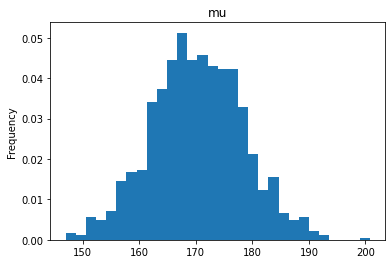

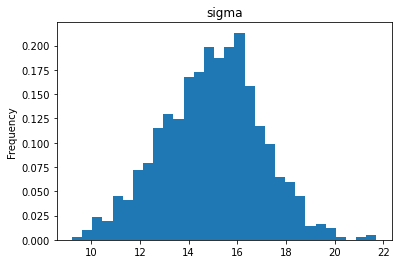

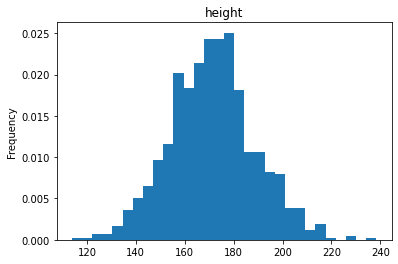

In [4]:
df1 = sim.draws_pd()

# 1.
for signal in ['mu', 'sigma', 'height']:
    df1[signal].plot.hist(bins=30, density=True)
    plt.title(signal)
    plt.show()

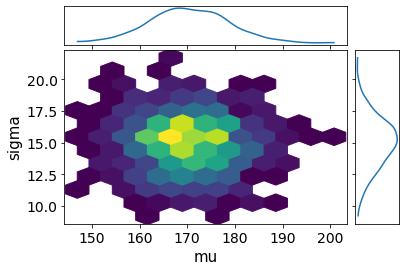

In [5]:
# 2.
az.plot_pair(sim, var_names=("mu", "sigma"), kind="hexbin", marginals=True)
plt.show()

In [6]:
# 3.
for signal in ['mu', 'sigma', 'height']:
    print(f'{signal}:  mean={df1[signal].mean()}  std={df1[signal].std()}]')

mu:  mean=170.30681699999997  std=8.106592452238962]
sigma:  mean=14.963684010000001  std=2.0128568333231938]
height:  mean=171.373087  std=17.429630630605754]


Based on obtained results we can see that samples are consistent with priors.

## Exercise 2 - Model fit and evaluation

In [7]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [8]:
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [9]:
df2 = fit.draws_pd()
df2.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma,height_pred
0,-904.268,1.000000,0.830305,2.0,7.0,0.0,904.330,154.036,8.38691,157.068
1,-904.282,0.992184,0.830305,2.0,7.0,0.0,905.024,155.056,7.39906,150.216
2,-904.663,0.962338,0.830305,2.0,7.0,0.0,906.169,153.933,8.39928,164.194
3,-905.051,0.979055,0.830305,2.0,3.0,0.0,905.378,153.973,8.50854,143.030
4,-902.286,1.000000,0.830305,2.0,3.0,0.0,904.794,154.482,7.98134,143.787


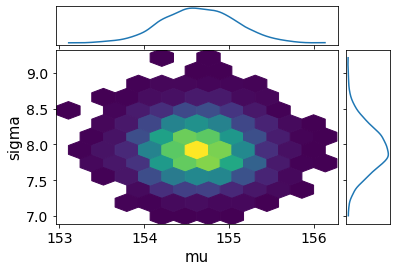

In [10]:
# 1.
az.plot_pair(fit, var_names=("mu", "sigma"), kind="hexbin", marginals=True)
plt.show()

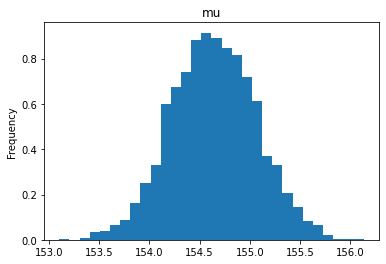

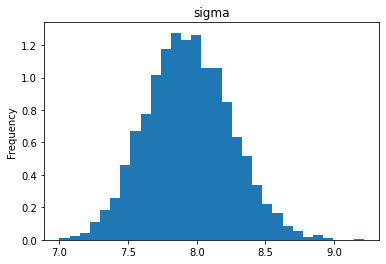

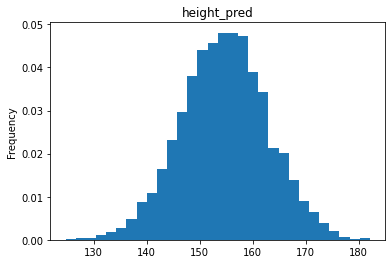

[]

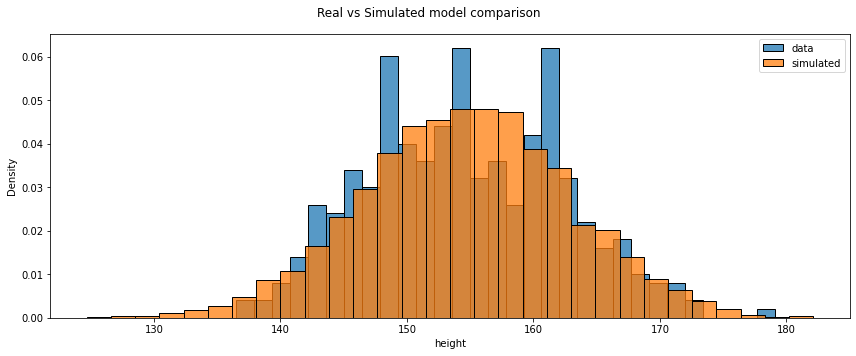

In [11]:
# 2.
for signal in ['mu', 'sigma', 'height_pred']:
    df2[signal].plot.hist(bins=30, density=True)
    plt.title(signal)
    plt.show()

fig, ax = plt.subplots(figsize=(12,5))
fig.suptitle("Real vs Simulated model comparison")
sns.histplot(data=d, x="height", bins=30, stat="density", ax=ax, label='data')
sns.histplot(data=df2, x="height_pred", bins=30, stat="density", ax=ax, label='simulated')
plt.legend()
plt.tight_layout()
plt.plot()

Obtained model is consistent with real one.

## Exercise 3 - Adding predictor to the model - weight

In [12]:
c_weight = d.weight - d.weight.mean()
d['c_weight'] = c_weight
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(), d.c_weight.max())}

## Exercise 4 - Prior predictive checks
 

In [13]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [14]:
df4 = sim.draws_pd()
df4.head()

,lp__,accept_stat__,alpha,beta,sigma,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,0.0,0.0,191.665,0.777181,13.7277,182.599,162.280,185.239,198.822,213.971,...,217.062,227.453,223.245,206.186,184.146,196.238,200.401,215.128,209.066,214.492
1,0.0,0.0,160.409,-0.006780,14.9963,178.721,171.889,171.587,178.157,178.679,...,200.412,159.956,146.819,157.962,146.022,168.035,144.686,158.799,179.852,159.148
2,0.0,0.0,166.584,-1.138640,13.7781,201.950,179.098,178.741,188.546,184.894,...,176.857,133.758,172.130,155.169,176.776,149.190,162.021,153.756,146.279,149.028
3,0.0,0.0,162.143,-0.254452,14.4921,184.945,155.957,162.196,151.371,161.824,...,167.149,161.133,164.401,179.353,152.018,151.279,170.996,150.954,163.607,152.397
4,0.0,0.0,162.052,1.671020,14.2973,101.473,131.426,129.762,130.995,161.655,...,204.814,202.167,174.066,188.155,184.725,181.334,181.274,200.793,199.272,180.499


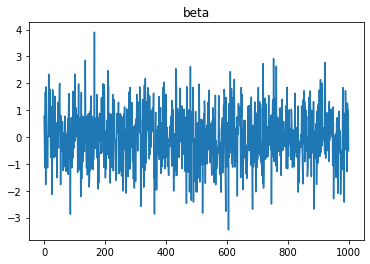

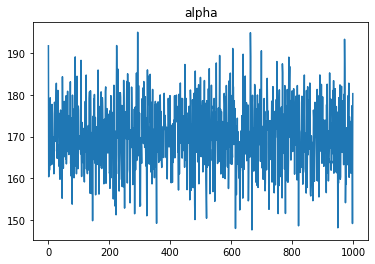

In [15]:
for signal in ['beta', 'alpha']:
    plt.plot(df4[signal])
    plt.title(signal)
    plt.show()

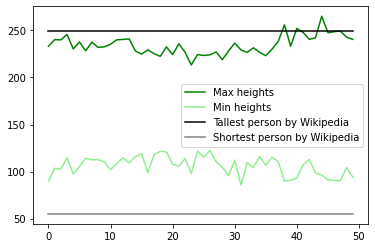

In [16]:
max_heights = []
min_heights = []
for i in range(1, 51):
    height_num = "height[" + str(i) + "]"
    max_heights.append(df4[height_num].max())
    min_heights.append(df4[height_num].min())

plt.plot(max_heights, label='Max heights', color='green')
plt.plot(min_heights, label='Min heights', color='lightgreen')
plt.plot([249] * len(max_heights), label='Tallest person by Wikipedia', color='black')
plt.plot([55] * len(max_heights), label='Shortest person by Wikipedia', color='gray')
plt.legend()
plt.show()

From above graph we can see than nearly every predicted height is between reasonable limits.

## Exercise 5 - Modifying prior


In [17]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [18]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [19]:
df5 = sim.draws_pd()
df5.head()

,lp__,accept_stat__,alpha,beta,sigma,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,0.0,0.0,191.665,1.214450,12.4555,176.350,158.246,179.409,192.065,206.141,...,220.890,230.650,227.164,212.018,192.352,203.656,207.765,221.459,216.290,221.545
1,0.0,0.0,160.409,0.998307,14.9926,164.727,158.551,158.904,166.127,167.304,...,212.603,172.811,160.332,172.127,160.846,183.508,160.819,175.584,197.287,177.242
2,0.0,0.0,166.584,0.752270,12.5563,173.899,154.240,155.080,165.181,163.020,...,197.674,159.563,195.698,181.407,202.264,178.291,191.150,184.784,179.136,182.807
3,0.0,0.0,162.143,0.938368,13.9842,167.667,140.466,147.258,137.583,148.441,...,181.345,176.311,180.235,195.434,169.829,169.888,189.685,171.117,184.097,174.052
4,0.0,0.0,162.052,1.518550,13.5945,105.430,133.864,132.237,133.363,162.470,...,201.858,199.296,172.530,185.881,182.574,179.304,179.201,197.715,196.222,178.326


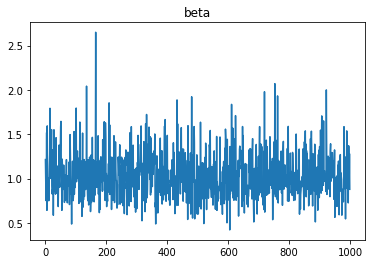

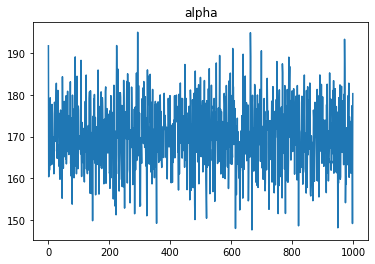

In [20]:
# 1.
for signal in ['beta', 'alpha']:
    plt.plot(df5[signal])
    plt.title(signal)
    plt.show()

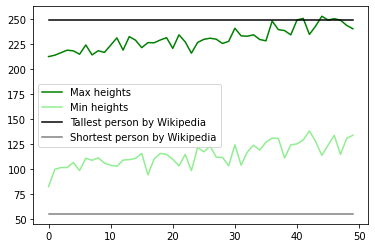

In [21]:
# 2.
max_heights = []
min_heights = []
for i in range(1, 51):
    height_num = "height[" + str(i) + "]"
    max_heights.append(df5[height_num].max())
    min_heights.append(df5[height_num].min())

plt.plot(max_heights, label='Max heights', color='green')
plt.plot(min_heights, label='Min heights', color='lightgreen')
plt.plot([249] * len(max_heights), label='Tallest person by Wikipedia', color='black')
plt.plot([55] * len(max_heights), label='Shortest person by Wikipedia', color='gray')
plt.legend()
plt.show()

## Exercise 6 - Fitting and evaluating model


In [22]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [23]:
data_fit = {'N':50, 'heights': d['height'].head(50), 'weight': d['weight'].head(50)}
fit=model_2_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status
chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [24]:
df6 = fit.draws_pd()
df6.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta,...,height_pred[41],height_pred[42],height_pred[43],height_pred[44],height_pred[45],height_pred[46],height_pred[47],height_pred[48],height_pred[49],height_pred[50]
0,-149.473,0.997664,0.314947,3.0,7.0,0.0,149.872,138.429,13.1110,0.383509,...,151.458,173.163,173.051,149.155,166.740,160.350,166.516,156.028,168.597,150.121
1,-149.225,0.999471,0.314947,4.0,15.0,0.0,150.047,124.037,11.4782,0.659539,...,140.255,173.644,148.284,158.312,156.316,150.833,162.221,146.527,144.650,143.280
2,-148.912,0.993617,0.314947,3.0,15.0,0.0,151.348,130.053,13.5126,0.560340,...,147.649,165.952,173.778,166.557,168.919,159.330,152.468,148.594,149.909,141.549
3,-148.021,0.992753,0.314947,3.0,15.0,0.0,149.620,127.863,11.6265,0.594381,...,174.039,162.218,160.634,159.692,173.380,160.816,160.317,141.741,170.353,151.998
4,-148.218,0.841035,0.314947,3.0,15.0,0.0,149.811,132.994,12.4711,0.523764,...,145.147,166.233,135.674,153.769,171.615,168.415,171.024,177.213,194.805,161.762


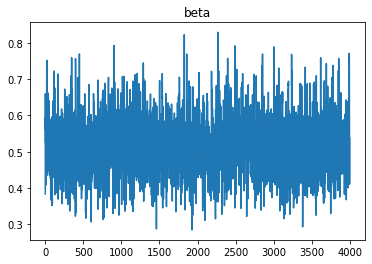

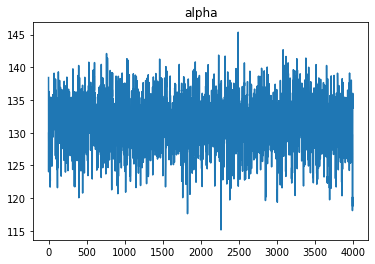

In [25]:
# 1.
for signal in ['beta', 'alpha']:
    plt.plot(df6[signal])
    plt.title(signal)
    plt.show()

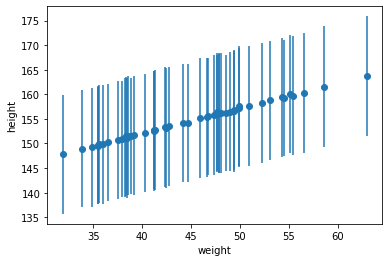

In [26]:
# 2.
weights = d['weight'].head(50)
heights = df6.iloc[:,60:110]
std = heights.std()[:50]
mean = heights.mean()[:50]

plt.figure()
plt.errorbar(weights, mean, yerr=std, fmt='o', elinewidth = 1.5)
plt.xlabel('weight')
plt.ylabel('height')
plt.show()

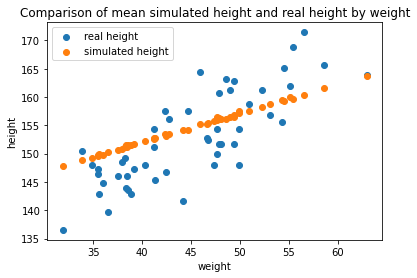

In [27]:
real_heights = d['height'].head(50)

plt.figure()
plt.scatter(weights, real_heights)
plt.scatter(weights, mean)
plt.title("Comparison of mean simulated height and real height by weight")
plt.xlabel('weight')
plt.ylabel('height')
plt.legend(["real height", "simulated height"])
plt.show()

## Exercise 7 - Extending the model



In [28]:
data_fit7={'N':50, 'heights': d['height'].head(50), 'weight':d['c_weight'].head(50)}
fit=model_2_fit.sample(data=data_fit7,seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [29]:
df7 = fit.draws_pd()
df7.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta,...,height_pred[41],height_pred[42],height_pred[43],height_pred[44],height_pred[45],height_pred[46],height_pred[47],height_pred[48],height_pred[49],height_pred[50]
0,-134.333,0.962576,0.777072,3.0,7.0,0.0,135.279,154.064,11.5889,0.702025,...,144.283,172.315,154.418,157.237,174.801,166.062,170.641,136.889,157.836,165.890
1,-133.514,0.997371,0.777072,3.0,7.0,0.0,134.746,153.085,10.8085,0.919494,...,146.337,183.619,136.827,152.716,145.959,175.383,163.927,169.069,142.217,177.978
2,-135.621,0.809256,0.777072,3.0,7.0,0.0,136.653,152.140,13.5648,1.033990,...,158.117,175.466,134.892,152.233,141.014,163.226,160.837,149.946,160.776,171.130
3,-134.630,1.000000,0.777072,2.0,3.0,0.0,135.581,151.983,12.7357,1.040630,...,131.292,178.733,129.170,165.255,148.212,185.405,172.831,155.456,163.505,137.856
4,-134.093,1.000000,0.777072,2.0,3.0,0.0,134.891,153.259,12.5120,1.069140,...,157.115,148.353,164.409,150.154,157.618,164.676,184.849,158.944,170.148,157.578


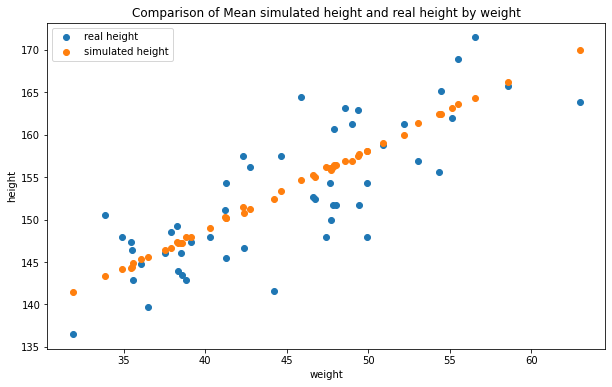

In [30]:
real_heights = d['height'].head(50)
heights = df7.iloc[:,60:110]
mean = heights.mean()[:50]
plt.figure(figsize=(10,6))
plt.scatter(weights, real_heights)
plt.scatter(weights, mean)
plt.title("Comparison of Mean simulated height and real height by weight")
plt.xlabel('weight')
plt.ylabel('height')
plt.legend(["real height", "simulated height"])
plt.show()